In [2]:
import pandas as pd
import re
from tqdm.auto import tqdm
import yfinance as yf
# import swifter
import numpy as np
from collections import OrderedDict

#載入PCA套件
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import matplotlib.colors as colors
plt.rcParams['font.sans-serif'] = ['SimHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

import quantstats as qs


/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tmp = pd.read_excel('Data/codes.xlsx', header = 1)
del tmp['#']
db = dict()
for i in range(0,len(tmp)):
    if tmp['英文代碼'][i] not in db.keys():
        db[tmp['英文代碼'][i]] = []
    db[tmp['英文代碼'][i]] =tmp['中文簡稱'][i]


In [ ]:
df = pd.DataFrame()
for i in range(2011, 2023):
    try:
        df_ = pd.read_csv('Data/'+str(i)+'_fut.csv', encoding = 'cp950', index_col = 0, low_memory=False)[['契約', '到期月份(週別)', '開盤價', '最高價', '最低價', '收盤價', '漲跌價', '漲跌%', '成交量','結算價', '未沖銷契約數', '最後最佳買價', '最後最佳賣價', '歷史最高價', '歷史最低價']]
    except:
        print(i)
        df_ = pd.read_csv('Data/'+str(i)+'_fut.csv', low_memory=False , index_col = 0)
    df = pd.concat([df,df_])

In [ ]:
df['中文名稱'] = df['契約'].apply(lambda x: db[x])
df['Type'] = df['中文名稱'].apply(lambda x: 0 if x in ['非金電期貨', '臺股期貨', '臺幣黃金期貨', '金融期貨', '電子期貨', '臺灣50期貨', '小型臺指期貨', '櫃買期貨', '黃金期貨', '十年期公債期貨', '三十天期利率期貨', '摩臺期'] else 1)
df['Type_'] = df['到期月份(週別)'].apply(lambda x: 0 if '/' in str(x) else 1)
df = df[(df['Type'] == 1) & (df['Type_'] == 1) & (df.index != '')] 
df.index = pd.to_datetime(df.index) 

In [ ]:
filter1 = re.compile(r'(.*?)[期]')
re.findall(filter1, '中信金期貨')
df['中文名稱'] = df['中文名稱'].apply(lambda x: re.findall(filter1, x)[0])
df['交易日期'] = df.index

In [ ]:
TEJ = pd.read_excel('Data/TEJ_20231126.xlsx')

In [ ]:
filter2 = re.compile(r'(.*?)[證]')
TEJ['名稱'] = TEJ['名稱'].apply(lambda x: re.findall(filter2, x)[0] if x[-2:] == '證券' else x)
TEJ['財報發布日'] = pd.to_datetime(TEJ['財報發布日']) 

In [ ]:
def find_closest_date(target_date, dates):
    try:
        tmp = dates.iloc[(dates - target_date).abs().argsort()[:1]].values[0]
    except:
        tmp = 'None'
    return tmp

In [ ]:
# df['財報發布日']  = df.apply(lambda x: find_closest_date(x['交易日期'],TEJ['財報發布日'][TEJ['名稱'] == x['中文名稱']]), axis = 1)


df['財報發布日']  = df.swifter.apply(lambda x: find_closest_date(x['交易日期'],TEJ['財報發布日'][TEJ['名稱'] == x['中文名稱']]), axis = 1)

In [ ]:
df.to_csv('df_merge.csv', index =False)

In [ ]:

# tmps = []
# error_tmps = []
# pbar = tqdm(df.iterrows(), total = (len(df)))
# for index, row in pbar:
#     try:
#         tmp = find_closest_date(row['交易日期'], TEJ['財報發布日'][TEJ['名稱'] == row['中文名稱']])
#         tmps.append(tmp)
#     except:
#         error_tmps.append(row['中文名稱'])

In [ ]:
df['財報發布日'] = df['財報發布日'].apply(lambda x: np.nan if x == 'None' else x)
df['財報發布日'] = pd.to_datetime(df['財報發布日'])

# 直接從這裏跑

In [ ]:
TEJ = pd.read_excel('Data/TEJ_20231126.xlsx')
filter2 = re.compile(r'(.*?)[證]')
TEJ['名稱'] = TEJ['名稱'].apply(lambda x: re.findall(filter2, x)[0] if x[-2:] == '證券' else x)
TEJ['財報發布日'] = pd.to_datetime(TEJ['財報發布日']) 

In [ ]:
df = pd.read_csv('df_merge.csv')
df['交易時段'] = df['交易時段'].fillna('一般')
df = df[df['交易時段'] == '一般']
df['財報發布日'] = df['財報發布日'].apply(lambda x: np.nan if x == 'None' else x)
df['財報發布日'] = pd.to_datetime(df['財報發布日'])

In [ ]:
data_code = pd.read_excel('Data/股名代碼.xlsx', header = 2)

In [ ]:
data_code = data_code.T.reset_index(drop=True).T

In [ ]:
tmp_1 = []
tmp_2 = []
tmp_3 = []
for i in range(0, len(data_code.T)):
    for j in range(0,len(data_code[i])):
        if pd.isna(data_code[i][j]) == False:
            if i%2 == 0:
                tmp_1.append(data_code[i][j].split('\xa0')[0])
            else:
                tmp_2.append(data_code[i][j].split('\xa0')[0])

df_code = pd.DataFrame()

In [ ]:
df_code = pd.DataFrame()
df_code['code'] = tmp_1
df_code['name'] = tmp_2

tmp_3 = []
tmp_4 = []
market = ''
sector = '' 
for i in range(len(tmp_1)):
    if tmp_1[i] == '上市' or tmp_1[i] == '上櫃':
       market = tmp_1[i]
       sector = tmp_2[i]
    tmp_3.append(market)
    tmp_4.append(sector)

df_code['sector'] = tmp_4
df_code['market'] = tmp_3
df_code['name'] = df_code['name'].apply(lambda x: str(x.split("＊")[0]) if len(x.split("＊"))>0 else str(x))
df_code['name'] = df_code['name'].apply(lambda x: str(x.split("＃")[0]) if len(x.split("＃"))>0 else str(x))

In [ ]:
df_name = list(set(df['中文名稱']))
name_dict = {}
for name in df_name:
    if name not in name_dict.keys():
        name_dict[name] = []
    if len(df_code['code'][(name == df_code['name'])]) > 0:
        name_dict[name] = df_code['code'][(name == df_code['name'])].iloc[0]
df['code'] = df['中文名稱'].apply(lambda x: name_dict[x])

In [ ]:
DB = pd.merge(df,TEJ,left_on = ['中文名稱','財報發布日'], right_on = ['名稱','財報發布日'])

In [ ]:
DB['收盤價'] = DB.swifter.apply(lambda x: x['收盤價'] if x['收盤價'] != '-' else x['結算價'], axis = 1) # 若當日流動量不足,改用結算價替代
DB['收盤價'] = DB['收盤價'].astype(float)

In [ ]:
# 定义一个函数来计算百分比变化 # gpt 好棒
def calculate_pct_change(group):
    group['Return'] = group['收盤價'].pct_change()
    return group

# 使用 groupby 和 apply 来应用这个函数
DB = DB.groupby(['契約', '到期月份(週別)']).apply(calculate_pct_change)

In [ ]:
DB_tmp = DB[['契約', '到期月份(週別)', '交易日期', 'Return']]

In [ ]:
DB_tmp['交易日期'] = pd.to_datetime(DB_tmp['交易日期'])

# 使用 pivot_table 来重塑 DataFrame
pivot_df = DB_tmp.pivot_table(index='交易日期', columns=['契約', '到期月份(週別)'], values='Return')


In [ ]:
# pivot_df.to_pickle("pivot_df.pkl")

# 找產業別, 組成Sector (可能採按市值加權)

In [3]:
tmp_df  = pd.read_pickle('pivot_df.pkl')

In [4]:
# 按照期貨契約加權：分個股期及小股期  # 只留大股票期貨 # 資料怪怪的：會把一些產業拔掉QQ
# 算法：採股期1:? -> ? * 股價
market_value = pd.read_excel('Data/股期市值.xlsx')
market_value_ = pd.DataFrame()
market_value_['代碼'] = market_value['股票期貨、'][3:]
market_value_['股數'] = market_value['標準型'][3:]
market_value_['代號'] = market_value['證券'][3:]
market_value_['簡稱'] = market_value['標的證券'][3:]
market_value_ = market_value_[market_value_['股數'] == 2000]

In [5]:
# 留下是期貨的
codes_chinese = pd.read_excel('Data/codes_sector.xlsx', header = 1)
codes_chinese['選擇權'] = codes_chinese['中文簡稱'].apply( lambda x : 0 if ('W' in x or '選' in x) else 1)
codes_chinese = codes_chinese[codes_chinese['選擇權'] == 1]
del codes_chinese['選擇權']
codes_chinese = codes_chinese.reset_index()
codes_chinese = codes_chinese[['英文代碼','中文簡稱']]
index = codes_chinese[codes_chinese['中文簡稱'] == '小型臺指']['中文簡稱'].index[0]
codes_chinese.loc[index, '中文簡稱'] = '小型臺指期貨'

In [6]:
sectors = pd.read_excel('Data/TEJ_產業別.xlsx')
sectors['產業類別'] = sectors['TSE新產業_名稱'].fillna(sectors['TEJ產業_名稱'])
filter2 = re.compile(r'(.*?)[證]')
sectors['名稱_'] = sectors['名稱'].apply(lambda x: re.findall(filter2, x)[0] if x[-2:] == '證券' else x)

In [7]:
filter3 = re.compile(r'(.*?)[期]')
codes_chinese['中文簡稱'] = codes_chinese['中文簡稱'].apply(lambda x: re.findall(filter3, x)[0])

In [8]:
codes_chinese['產業'] = 0
codes_chinese['代號'] = 0
codes_chinese['上市別'] = 0
for i in range(len(codes_chinese['中文簡稱'])):
    tmp = codes_chinese['中文簡稱'][i]
    for j in range(len(sectors['產業類別'])):
        sector = sectors['產業類別'][j]
        code = sectors['代號'][j]
        market_type = sectors['上市別'][j]

        if tmp in sectors['名稱_'][j]:
            codes_chinese['產業'][i] = sector
            codes_chinese['代號'][i] = code
            codes_chinese['上市別'][i] = market_type

            break
codes_chinese = codes_chinese[codes_chinese['產業'] != 0]

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

# 加入市值相乘 
# Way1: 取得每日收盤價作為乘數
# Way2: 取得 每日收盤價*股本 作為乘數


In [9]:
# 取得要求ticker們
codes_chinese['上市別'] = codes_chinese['上市別'].fillna(0)
codes_chinese['Tickers'] = codes_chinese.apply(lambda x: str(x['代號']) + '.TW' if x['上市別'] == 'TSE' else str(x['代號']) + '.TWO' if x['上市別'] == 'OTC' else '', axis = 1)

tickers = ''
for i in range(0,len(codes_chinese)):
    tickers += codes_chinese['Tickers'].iloc[i]+' '

In [10]:
price_data = yf.download(tickers)['Close']
price_data.to_pickle('Data/price_data.pkl')
price_data = price_data[price_data.index > pd.to_datetime('20110101')]

[*********************100%***********************]  326 of 326 completed


# 按照Sector分類，將同樣Sector之股票期貨return 組為一組return

In [11]:
tmps = list(tmp_df.T.index)
new_index = []
for tmp in tmps:
    name = tmp[0]
    new = list(tmp)
    industry = codes_chinese[codes_chinese['英文代碼'] == name]['產業'].values[0]
    ticker = codes_chinese[codes_chinese['英文代碼'] == name]['Tickers'].values[0]
    new.append(industry)
    new.append(ticker)
    new_index.append(tuple(new))
    
new_df = tmp_df.T
new_df.index = pd.MultiIndex.from_tuples(new_index, names=['契約', '到期月份(週別)', '產業別', 'ticker'])
new_df = new_df.T

In [13]:
all_future = list(set(new_df.keys().get_level_values('契約')))
futures = []
for future in all_future:
    if future[2] == 'F':
        futures.append(future)
new_df = new_df[futures]
all_future = list(set(new_df.keys().get_level_values('契約')))
all_term = list(set(new_df.keys().get_level_values('到期月份(週別)')))
all_sector = list(set(new_df.keys().get_level_values('產業別')))

In [14]:
price_data.index.name = '交易日期'
price_data  = price_data[price_data.index < pd.to_datetime('20230101')]

In [15]:
value = pd.read_excel('Data/Value_Ticker.xlsx')
value['財報發布日'] = pd.to_datetime(value['財報發布日'])

In [55]:
Value_Data = pd.DataFrame(index = price_data.index) # 財報公告日資料重複
for col in tqdm(price_data.columns):
    test = value[value['Tickers'] == col]
    test.index = test['財報發布日'].values
    value_data = pd.DataFrame(index = price_data.index)

    tmp = pd.merge(value_data,test['  股本'], left_index = True, right_index = True, how = 'outer')
    tmp['date'] = tmp.index
    tmp.drop_duplicates(subset='date', keep='last', inplace=True)
    tmp = tmp.ffill()

    tmp['here'] = tmp.apply(lambda x: 1 if x.date in list(price_data.index) else 0 ,axis = 1)
    tmp = tmp[tmp['here'] == 1]

    Value_Data[col] = tmp['  股本']

 31%|███       | 100/326 [06:20<14:23,  3.82s/it]/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app
 31%|███       | 101/326 [06:24<14:15,  3.80s/it]/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app
 31%|███▏      | 102/326 [06:27<14:09,  3.79s/it]/home/akilin/anaconda3/envs/gamma/lib/p

In [57]:
#  運用代碼，對回去contract，再乘上相符的日期
DF = pd.DataFrame()
for column in tqdm(price_data.columns):
    try:
        df_contract = new_df.xs((column), level = ('ticker'), axis = 1)
    except:
        continue
    # df_stock = Value_Data[column]*price_data[column]
    df_stock = price_data[column]

    test = pd.DataFrame()
    test.index = df_contract.index
    test['市值'] = df_stock

    result_df = pd.DataFrame(df_contract*(test.values))

    DF = pd.concat([DF,result_df],axis = 1)

100%|██████████| 326/326 [00:13<00:00, 23.82it/s]


In [59]:
DB = pd.DataFrame()
DB.index = DF.index
all_sector = list(set(DF.keys().get_level_values('產業別'))) # '罐頭加工'
for sector in tqdm(all_sector):
    db = pd.DataFrame()
    db.index = DF.index
    for term in all_term:
        test_df = DF.xs((term,sector), level = ('到期月份(週別)','產業別'), axis = 1)
        test_df[sector] = test_df.mean(axis = 1) # 把相同週別加在一起
        test_df['到期月份(週別)'] = term
        test_df = test_df[test_df[sector] != 0]
        db = pd.concat([db,test_df])
    if sector == all_sector[0]:
        DB = DB.merge(db[[sector, '到期月份(週別)']], left_on = ['交易日期'], right_on = ['交易日期'])
    else:
        DB = DB.merge(db[[sector, '到期月份(週別)']], left_on = ['交易日期', '到期月份(週別)'], right_on = ['交易日期', '到期月份(週別)'], how = 'outer')
    # DB[sector] = db[sector].values

  0%|          | 0/32 [00:00<?, ?it/s]/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


In [60]:
# 暫時先用直接相加取代
DB_new = DB.groupby('交易日期').mean().fillna(0)
T = 125

#輸入有多少成分我們想要留住分解
N = 2
pca = PCA(n_components = 2)

In [61]:
DB_new = DB_new[['生技醫療','汽車工業', '貿易百貨', '半導體', '橡膠工業', '運動休閒', '建材營造',
       '通信網路業', '電子零組件', '紡織纖維', '其他', '航運業', '食品工業', '水泥工業', '塑膠工業', '玻璃陶瓷',
       '文化創意業', '化學工業', '造紙工業', '金融業', '綠能環保', '電腦及週邊', '電機機械', '觀光餐旅', '居家生活',
       '光電業', '鋼鐵工業', '其他電子業', '數位雲端', '電器電纜', '資訊服務業', '電子通路業']]
# DB_new = DB_new[DB_new.index > pd.to_datetime('2008-01-01')]
half_life = list((1/2)**(np.arange(T,0,-1)/T))
DF = pd.DataFrame(DB_new.rolling(T))

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [62]:
dates = []
centralities = {}
for i in tqdm(range(T, len(DF))):
# for i in range(T, T+5):
    df = DF.iloc[i,0].mul(half_life, axis = 0)
    date = df.index[-1]
    
    #將資料分成兩個主成份
    X = df.cov()
    pca.fit(X)
    x_pca = pca.transform(X)

    # 主成份的解釋力
    absorption_ratios = pca.explained_variance_ratio_

    # 各產業集中度
    # centralities = {'產業集中度':[]}
    centralities[date] = []
    for i in range(len(x_pca)):
        eigien_ratio = 0
        for j in range(0,N):
            eigien_ratio += (np.abs(x_pca[i,j])/ np.abs(x_pca.T[j]).sum())*absorption_ratios[j]
        centrality = eigien_ratio/absorption_ratios.sum()
        centralities[date].append(centrality)
        
centralities = pd.DataFrame(centralities)
centralities.index = df.keys()
centralities = centralities.T

100%|██████████| 2823/2823 [00:05<00:00, 515.76it/s]


In [66]:
DAYS = 252*3 # 可能要調
standard_centralities = (centralities - centralities.rolling(DAYS).mean())/centralities.rolling(DAYS).std()

In [67]:
cmap = colors.LinearSegmentedColormap.from_list("brw", ["white", "blue", "red"], N = 33)

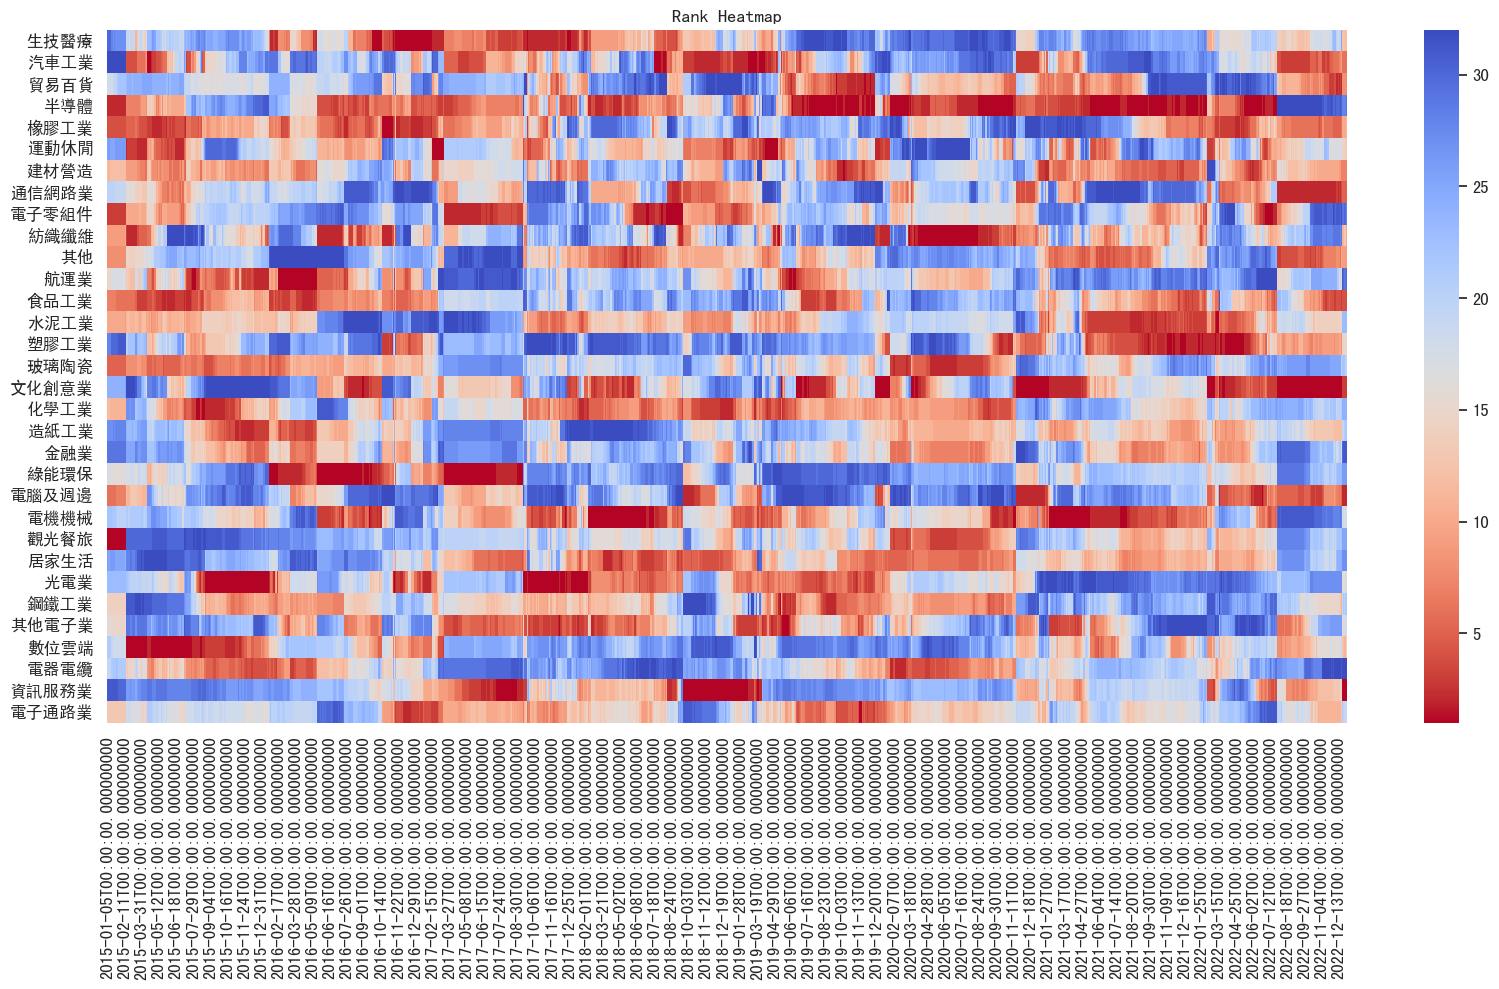

In [196]:
# rank_centralities = centralities.rank(axis = 1, ascending = False).T
rank_centralities = standard_centralities.rank(axis = 1, ascending = False).T
plt.figure(figsize = (20,9))
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})
sns.heatmap(rank_centralities.T['2015':].T, annot = False, cmap='coolwarm_r')
plt.title('Rank Heatmap')
plt.savefig('Rank Heatmap.png')
plt.show()

# Relative Value

In [69]:
# P/B ratio from TEJ
PB = pd.read_excel('Data/TEJ_20231126.xlsx')

In [70]:
test = []
test_ = []
codes_chinese = codes_chinese.reset_index(drop = True)
for i in tqdm(range(0,len(PB))):
    count = 'Unknown'
    count_ = 'Unknown'
    for j in range(0,len(codes_chinese)):
        if PB['名稱'][i] == codes_chinese['中文簡稱'][j]:
            count = codes_chinese['產業'][j]
            count_ = codes_chinese['Tickers'][j]
            break
    test.append(count)
    test_.append(count_)
PB['產業'] = test
PB['Tickers'] = test_

100%|██████████| 117889/117889 [04:48<00:00, 408.46it/s]


In [71]:
PB.to_excel('Data/Value_Ticker.xlsx', index = False)

# PB ranking

In [72]:
price_data  = price_data[price_data.index > pd.to_datetime('20110101')]

In [73]:
PB = PB[PB['產業'] != 'Unknown']
PB['財報發布日'] = pd.to_datetime(PB['財報發布日'])
PB = PB[PB['財報發布日'] > '2011-01-01']
PB = PB[PB['財報發布日'] < '2023-01-01']

In [74]:
PB_Data = pd.DataFrame(index = price_data.index) # 財報公告日資料重複
for col in tqdm(price_data.columns):
    test = PB[PB['Tickers'] == col]
    test.index = test['財報發布日'].values
    PB_data = pd.DataFrame(index = price_data.index)

    tmp = pd.merge(PB_data,test['每股淨值(B)'], left_index = True, right_index = True, how = 'outer')
    tmp['date'] = tmp.index
    tmp.drop_duplicates(subset='date', keep='last', inplace=True)
    tmp = tmp.ffill()

    tmp['here'] = tmp.apply(lambda x: 1 if x.date in list(price_data.index) else 0 ,axis = 1)
    tmp = tmp[tmp['here'] == 1]

    PB_Data[col] = tmp['每股淨值(B)']



 31%|███       | 100/326 [05:53<13:21,  3.55s/it]/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app
 31%|███       | 101/326 [05:56<13:18,  3.55s/it]/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app
 31%|███▏      | 102/326 [06:00<13:18,  3.57s/it]/home/akilin/anaconda3/envs/gamma/lib/p

In [75]:
PB_ratio = (price_data/PB_Data).T

In [76]:
# PB_ratio['sector'] = []
test = []
for tmp in PB_ratio.index:
    test.append((tmp, codes_chinese['產業'][codes_chinese['Tickers'] == tmp].iloc[0]))

PB_ratio.index = pd.MultiIndex.from_tuples(test, names=['Ticker','產業'])
PB_ratio = PB_ratio.T
PB_sector = PB_ratio.T.groupby('產業').sum().T

In [77]:
DAYS = 252*3
tmp = PB_sector/PB_sector.rolling(DAYS).mean()
PB_star = pd.DataFrame()
for sector in list(PB_sector.columns):
    columns = list(PB_sector.columns)
    columns.remove(sector)
    PB_star[sector] = tmp[sector]/(tmp[columns]).mean(axis = 1)

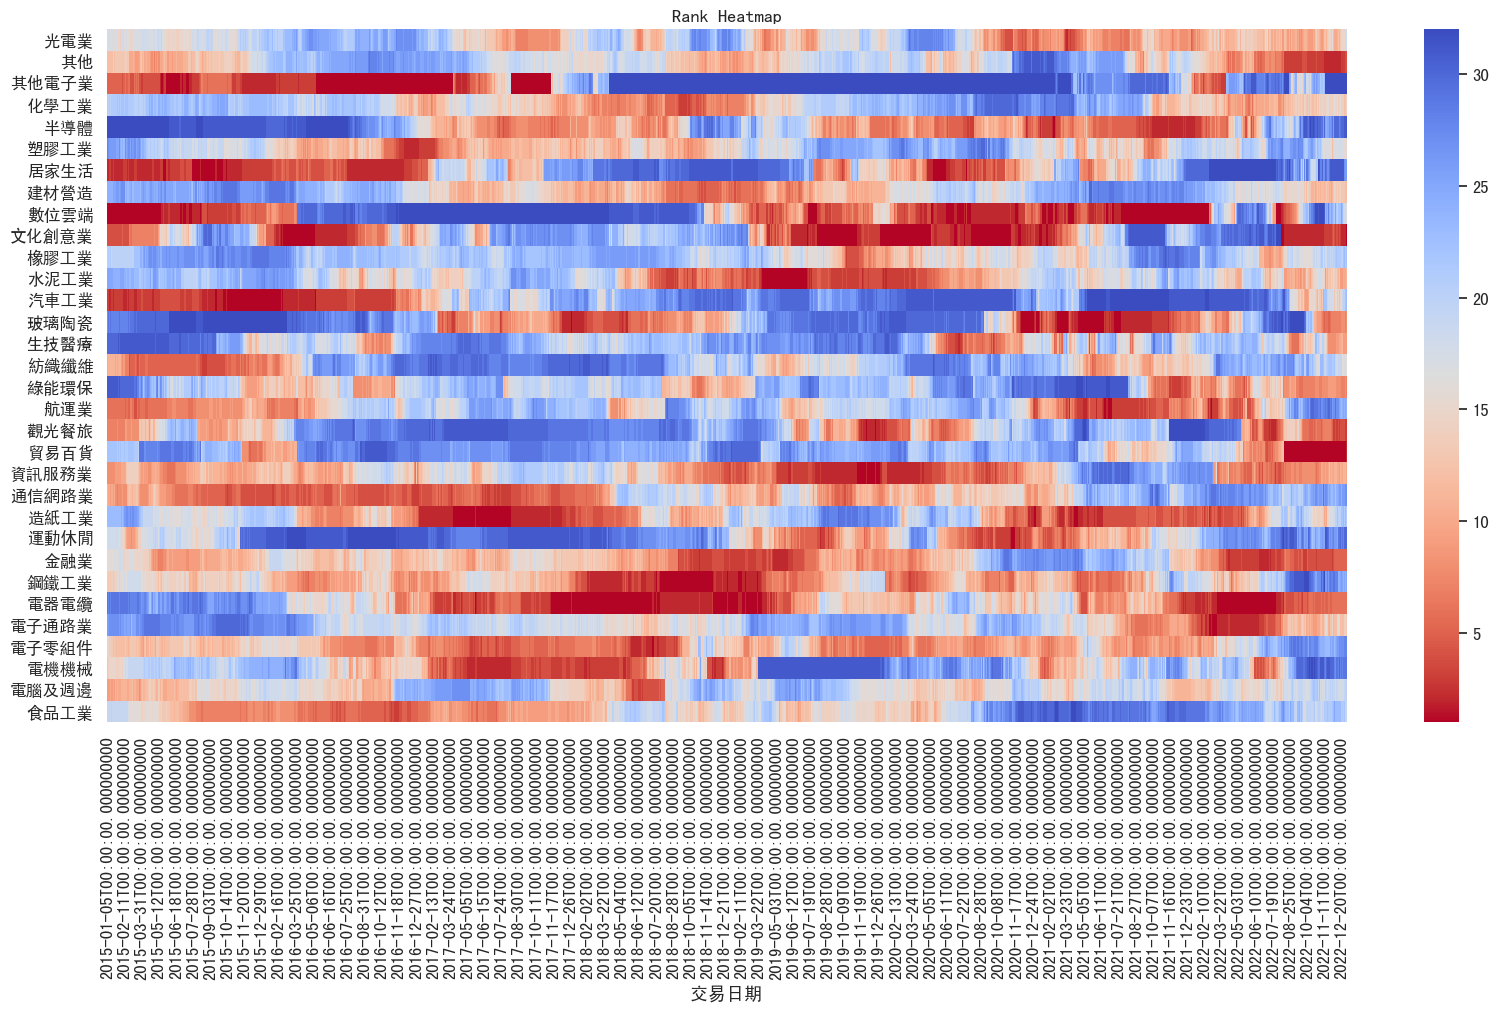

In [197]:
rank_PB_star = PB_star.rank(axis = 1, ascending = False).T
plt.figure(figsize = (20,9))
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})
sns.heatmap(rank_PB_star.T['2015':].T, annot = False, cmap='coolwarm_r')
plt.title('Rank Heatmap')
plt.savefig('Rank Heatmap.png')
plt.show()

# Conditional Sector Performance

In [249]:
DB = pd.DataFrame()
DB.index = new_df.index
all_sector = list(set(new_df.keys().get_level_values('產業別'))) # '罐頭加工'
for sector in tqdm(all_sector):
    db = pd.DataFrame()
    db.index = new_df.index
    for term in all_term:
        test_df = new_df.xs((term,sector), level = ('到期月份(週別)','產業別'), axis = 1)
        test_df[sector] = test_df.mean(axis = 1)
        test_df['到期月份(週別)'] = term
        test_df = test_df[test_df[sector] != 0]
        db = pd.concat([db,test_df])
    if sector == all_sector[0]:
        DB = db[[sector, '到期月份(週別)']]
    else:
        DB = DB.merge(db[[sector, '到期月份(週別)']], left_on = ['交易日期', '到期月份(週別)'], right_on = ['交易日期', '到期月份(週別)'], how = 'outer')
    # DB[sector] = db[sector].values

  0%|          | 0/33 [00:00<?, ?it/s]/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
  6%|▌         | 2/33 [00:02<00:50,  1.64s/it]/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pandas/core/generic.

In [250]:
DB = DB.T
DB.index = [tmp[0] for tmp in DB.index]
DB = DB.T

DB_new = DB.groupby('交易日期').mean()
del DB_new['到期月份(週別)']

In [251]:
rank_PB_star = rank_PB_star.T
rank_PB_star['date'] = rank_PB_star.index
rank_centralities = rank_centralities.T
rank_centralities['date'] = rank_centralities.index

In [252]:
filter = list(set(set(rank_PB_star.index)).intersection(set(rank_centralities.index)))
rank_PB_star['here'] = rank_PB_star.apply(lambda x: 1 if x.date in filter else 0, axis = 1)
rank_centralities['here'] = rank_centralities.apply(lambda x: 1 if x.date in filter else 0, axis = 1)

In [253]:
rank_PB_star =  rank_PB_star[rank_PB_star['here']==1]
rank_centralities = rank_centralities[rank_centralities['here']==1]
rank_PB_star = rank_PB_star[rank_centralities.columns]
del rank_PB_star['here']
del rank_PB_star['date']
del rank_centralities['here']
del rank_centralities['date']

In [254]:
filter = list(set(set(DB_new.index)).intersection(set(rank_PB_star.index)))
DB_new['date'] = DB_new.index
DB_new['here'] = DB_new.apply(lambda x: 1 if x.date in filter else 0, axis = 1)
DB_new = DB_new[DB_new['here'] == 1]
del DB_new['here']
del DB_new['date']

In [255]:
DB_new_ = DB_new[DB_new.index > pd.to_datetime('2019-01-01')]

In [256]:
def get_results(result_type, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = DB_new):
    if result_type == 1:
        rank_PB_star_bool = rank_PB_star > 8
        rank_centralities_bool = rank_centralities > 8

    elif result_type == 2:
        rank_PB_star_bool = rank_PB_star <= 8
        rank_centralities_bool = rank_centralities > 8

    elif result_type == 4:
        rank_PB_star_bool = rank_PB_star <= 8
        rank_centralities_bool = rank_centralities <= 8

    elif result_type == 3:
        rank_PB_star_bool = rank_PB_star > 8
        rank_centralities_bool = rank_centralities <= 8

    bool_df = (rank_PB_star_bool*rank_centralities_bool).shift(1)

    DB_new = DB_new*bool_df
    yearly_return = (DB_new*bool_df).mean()*252

    return DB_new, yearly_return

In [257]:
df_results = pd.DataFrame()

no_b_1, df_results['no bubble_1'] = get_results(result_type = 1)
no_b_2, df_results['no bubble_2'] = get_results(result_type = 2)
b_r, df_results['bubble runup'] = get_results(result_type = 3)
b_s, df_results['bubble selloff'] = get_results(result_type = 4)
df_results

,no bubble_1,no bubble_2,bubble runup,bubble selloff
光電業,-0.076871,0.016341,-0.003260,-0.003036
其他,-0.124213,-0.011105,-0.015408,-0.005374
其他電子業,-0.003170,-0.082198,0.020045,0.008649
化學工業,-0.237200,-0.006156,-0.031871,-0.028113
半導體,-0.059055,-0.009726,0.021678,0.052427
塑膠工業,-0.039185,-0.014533,-0.017649,0.002925
居家生活,-0.043114,-0.381322,-0.128759,-0.008964
建材營造,-0.101505,-0.020998,-0.112289,0.000000
數位雲端,-0.046534,-0.048834,-0.043349,-0.034147
文化創意業,-0.157569,-0.392986,-0.073939,-0.008631


In [258]:
df_results.mean()


no bubble_1      -0.096106
no bubble_2      -0.049269
bubble runup     -0.049196
bubble selloff   -0.006160
dtype: float64

In [259]:
# 大盤
market = yf.download('^TWII')['Close']
market_return = market[market.index > pd.to_datetime('2011-01-01')].pct_change()

[*********************100%***********************]  1 of 1 completed


                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          51.9%
CAGR﹪                     5.37%

Sharpe                     0.42
Prob. Sharpe Ratio         87.71%
Smart Sharpe               0.41
Sortino                    0.58
Smart Sortino              0.57
Sortino/√2                 0.41
Smart Sortino/√2           0.4
Omega                      1.08

Max Drawdown               -31.63%
Longest DD Days            744
Volatility (ann.)          15.86%
Calmar                     0.17
Skew                       -0.5
Kurtosis                   4.92

Expected Daily %           0.02%
Expected Monthly %         0.44%
Expected Yearly %          5.36%
Kelly Criterion            3.87%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.62%
Expected Shortfall (cVaR)  -1.62%

Max Consecutive Wins       9


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-05,2022-10-25,2022-12-30,359,-31.631863,-30.851297
2,2020-01-15,2020-03-19,2020-07-09,176,-28.723517,-24.311871
3,2015-04-28,2015-08-24,2017-05-11,744,-25.696876,-22.362513
4,2018-01-24,2019-01-04,2019-10-22,636,-16.622965,-15.394147
5,2021-04-28,2021-05-17,2021-06-29,62,-12.741665,-10.944599


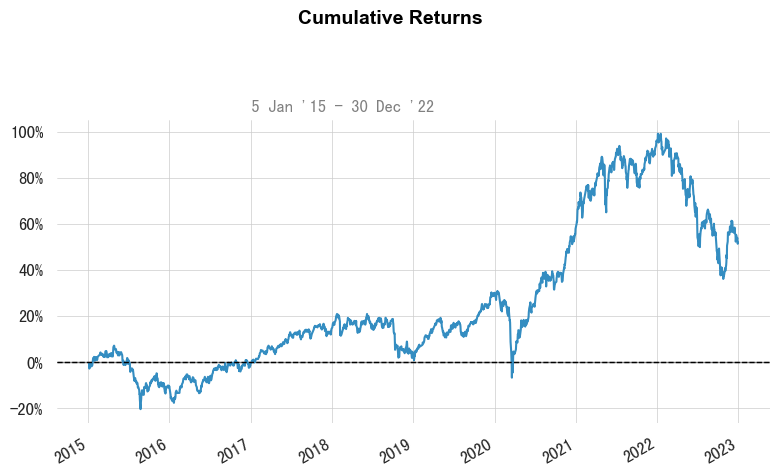

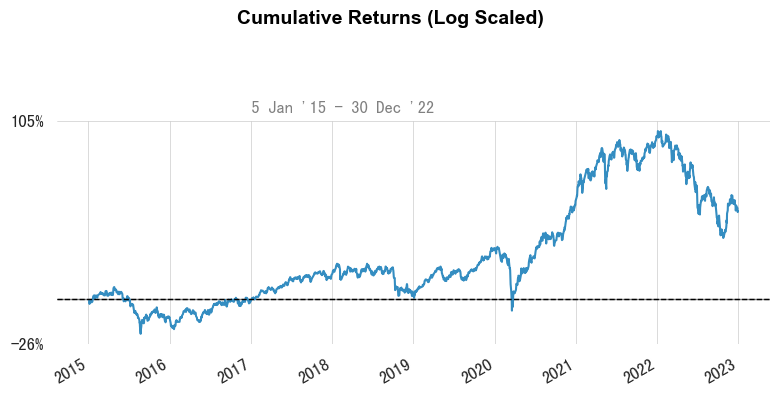

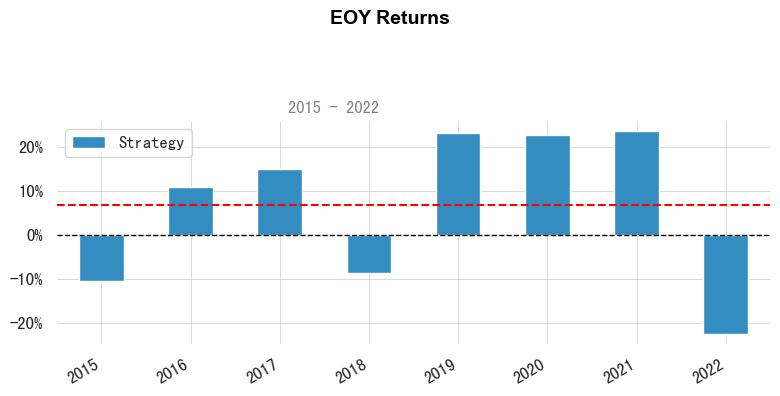

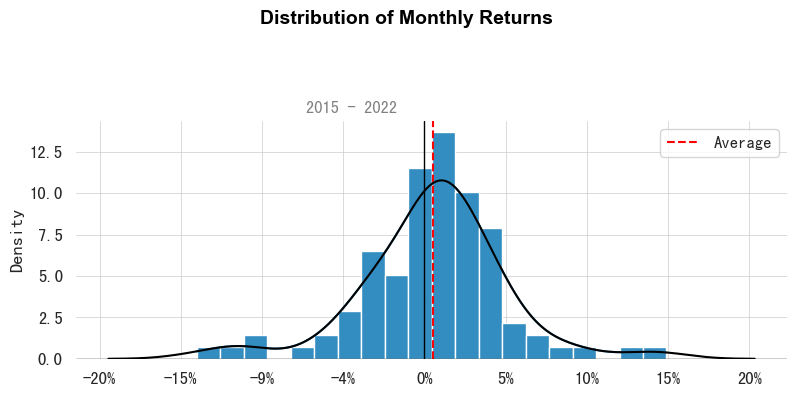

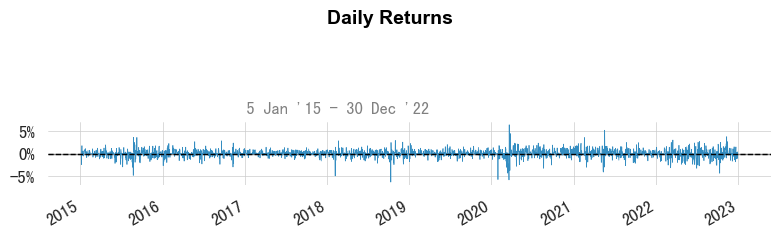

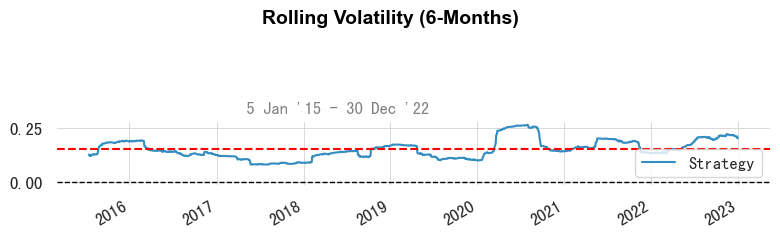

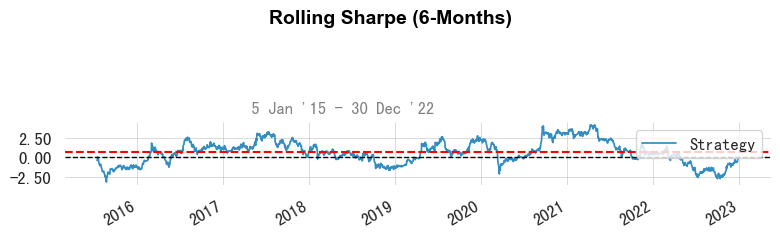

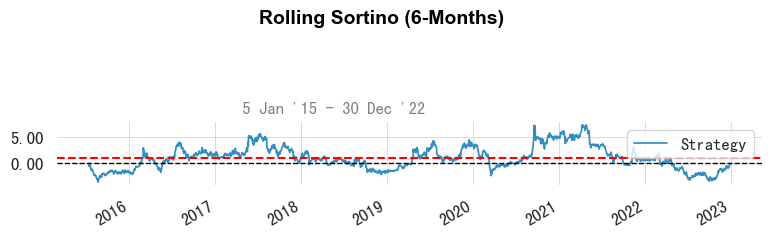

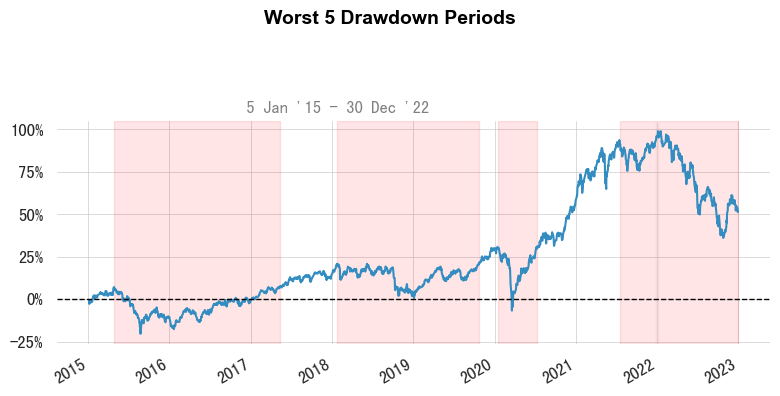

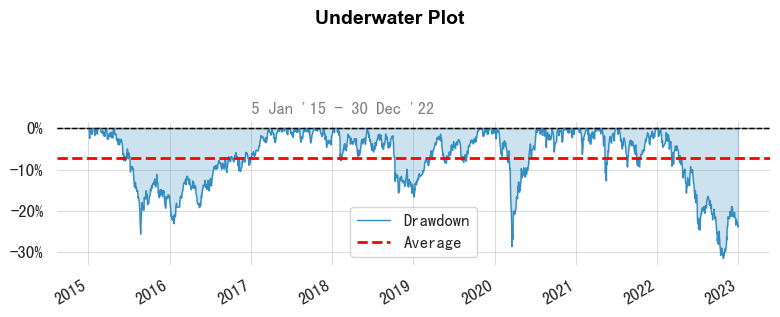

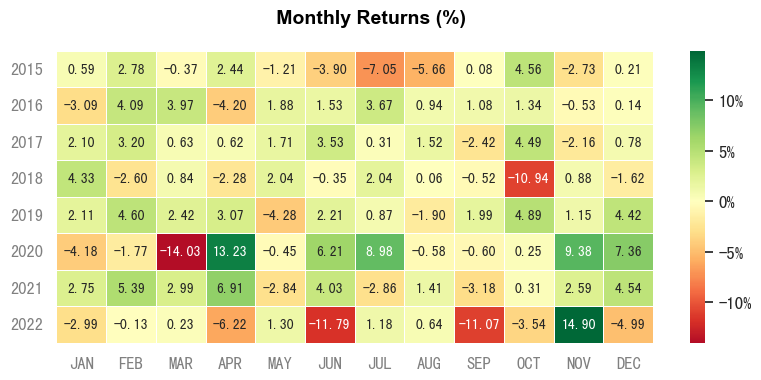

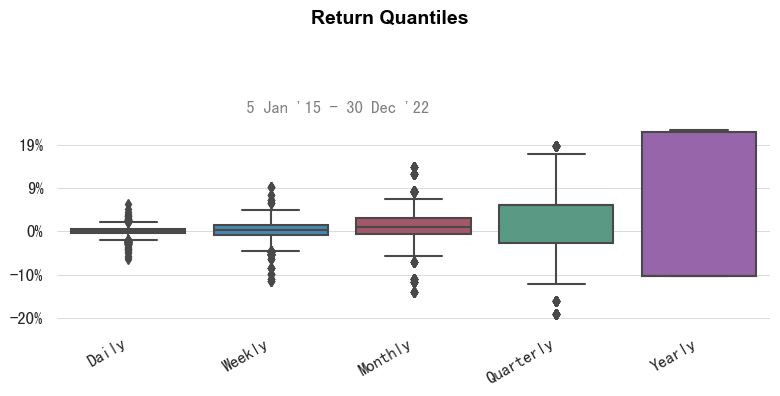

In [260]:
qs.reports.full(market_return['2015':'2022'])

                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          47.16%
CAGR﹪                     4.96%

Sharpe                     1.27
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.26
Sortino                    2.63
Smart Sortino              2.61
Sortino/√2                 1.86
Smart Sortino/√2           1.84
Omega                      1.31

Max Drawdown               -10.23%
Longest DD Days            1015
Volatility (ann.)          4.01%
Calmar                     0.48
Skew                       3.85
Kurtosis                   39.79

Expected Daily %           0.02%
Expected Monthly %         0.4%
Expected Yearly %          4.95%
Kelly Criterion            11.45%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.4%
Expected Shortfall (cVaR)  -0.4%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-20,2021-04-20,2022-12-30,1015,-10.225663,-9.985278
2,2018-10-31,2019-03-19,2020-03-11,497,-4.592578,-4.402470
3,2015-08-25,2015-10-20,2015-12-14,111,-2.727070,-2.630569
4,2018-03-26,2018-04-11,2018-04-24,29,-1.207865,-1.186351
5,2016-06-17,2016-07-19,2016-07-20,33,-1.142279,-1.105075


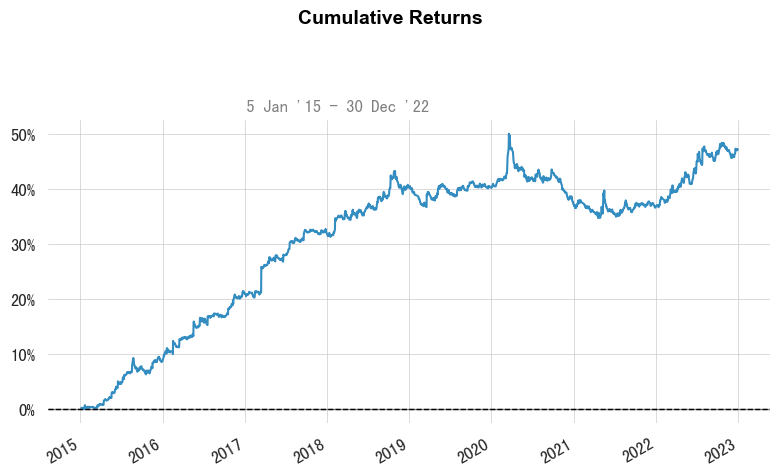

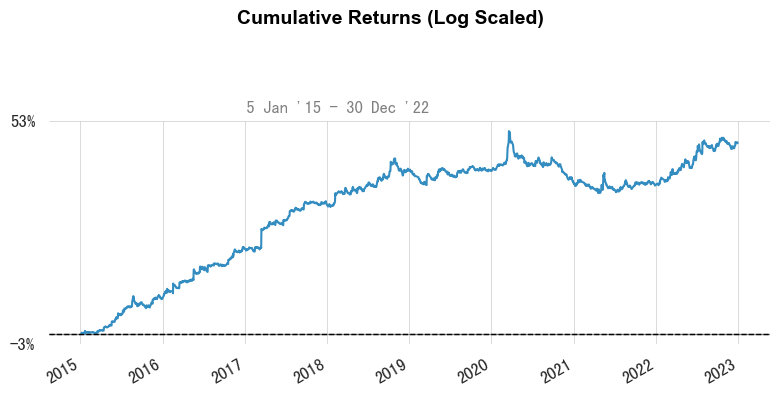

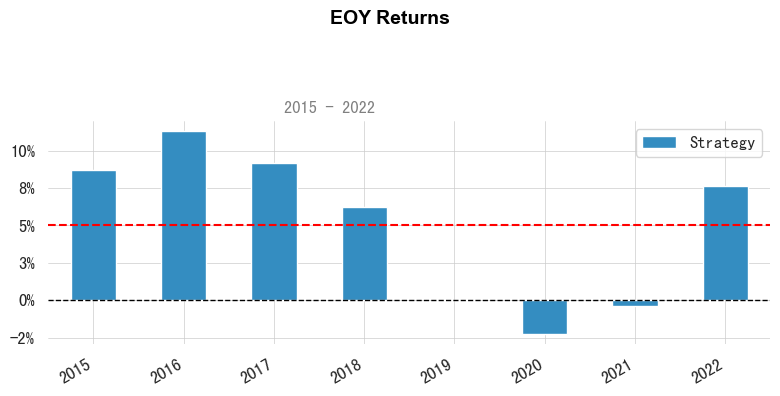

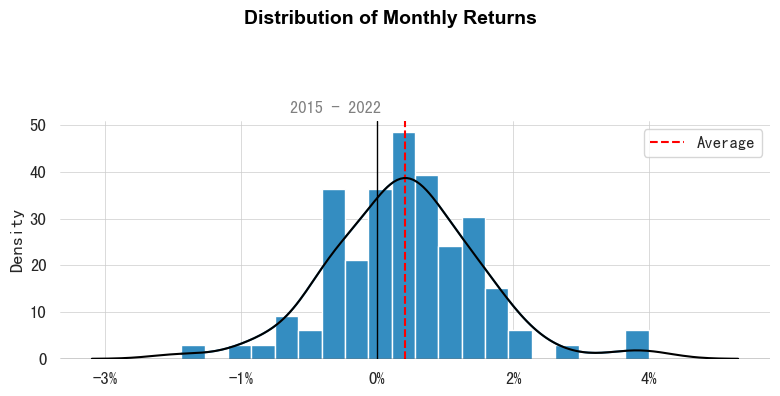

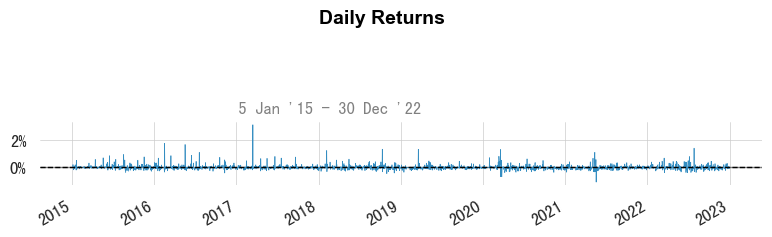

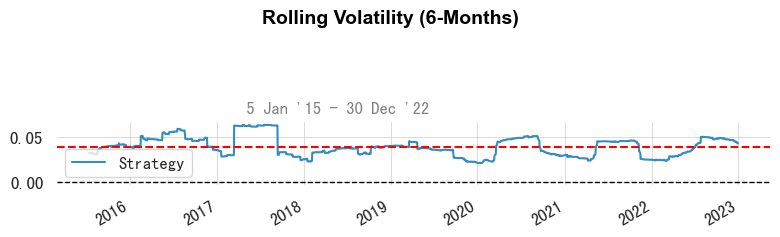

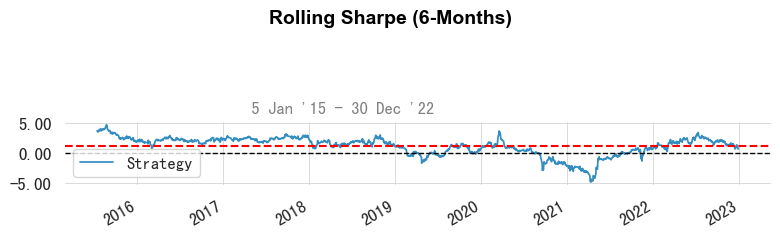

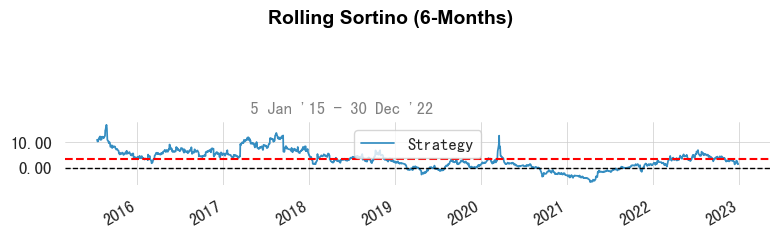

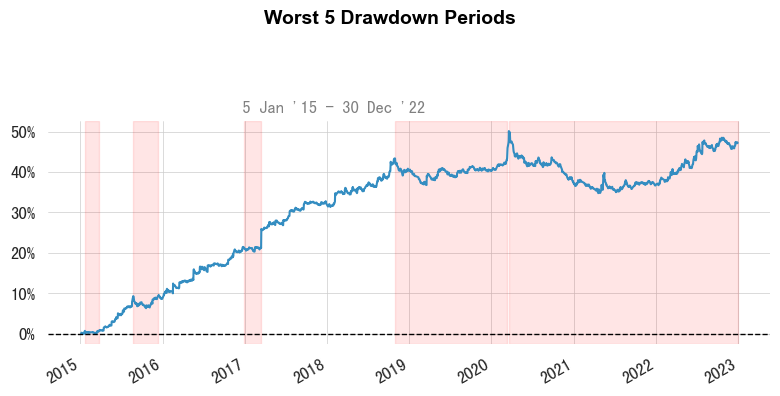

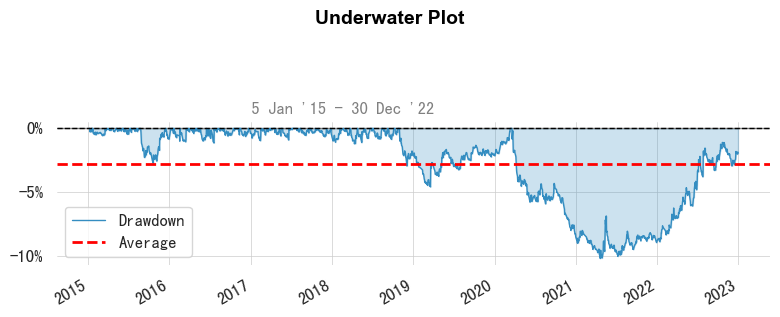

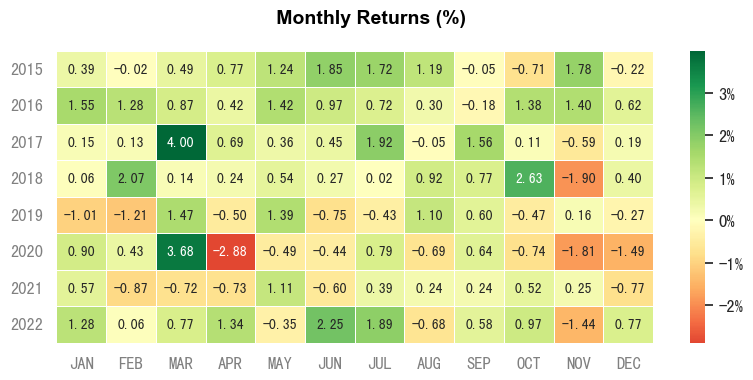

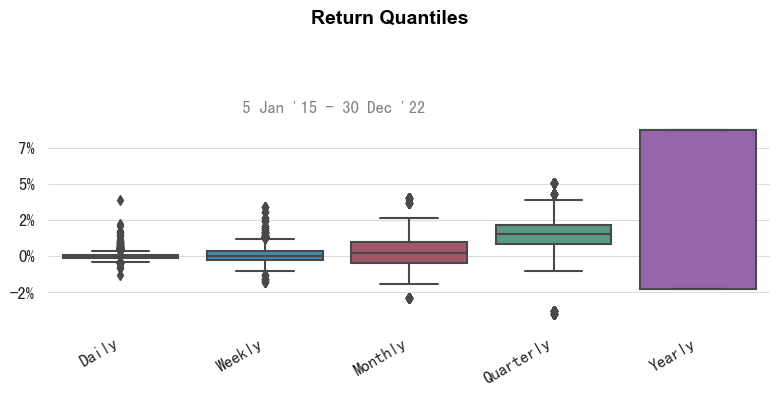

In [272]:
qs.reports.full(-b_r['2015':'2022'].mean(axis = 1))

# Trading-rule

# Black - Litterman

In [262]:
from pypfopt.black_litterman import BlackLittermanModel

In [263]:
df = yf.download()

TypeError: download() missing 1 required positional argument: 'tickers'

In [ ]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()